In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import numpy as np
import seaborn as sns

In [3]:
germany_gdf = gpd.read_file('data/germany_shape/georef-germany-kreis-millesime.shp')
germany_gdf['lan_name'] = germany_gdf['lan_name'].apply(lambda x: x[2:-2] if isinstance(x, str) else x)
grouped_gdf = germany_gdf.dissolve(by='lan_code')

zv_df = pd.read_csv('data/zwangsversteigerungen.csv')
wohnungen_df = zv_df[zv_df['typ'] == 'Wohnung']

### Analyse Zwangsversteigerungen

In [3]:
def visualize_data_by_bundesland(merged_gdf, column_name=None, title_prefix="", cmap_name = "Blues", boxplot_df = None):
    merged_sorted = merged_gdf.sort_values(column_name, ascending=True)

    cmap = mpl.colormaps[cmap_name]
    colors = [cmap(i / len(merged_sorted)) for i in range(len(merged_sorted))]

    fig, (ax_map, ax_chart) = plt.subplots(1, 2, figsize=(12, 6))

    merged_gdf.plot(column=column_name, ax=ax_map, legend=True, cmap=cmap_name, edgecolor='black')
    ax_map.set_title(f'{title_prefix} by Bundesland ', fontsize=16)
    ax_map.set_axis_off()

    if boxplot_df is not None:
        grouped = boxplot_df.groupby('lan_name')[column_name].apply(lambda x: x.dropna().median())
        sorted_names = grouped.sort_values().index
        grouped_data = [boxplot_df[boxplot_df['lan_name'] == name][column_name].dropna() for name in sorted_names]
        box = ax_chart.boxplot(grouped_data, tick_labels=sorted_names, vert=False, patch_artist=True)

        for median in box['medians']:
            median.set(color='orange', linewidth=1.75)
        
        ax_chart.set_xlabel(column_name.title())
        ax_chart.set_title(f'Boxplot of {column_name.title()} for Bundesländer', fontsize=16)
    else:
        ax_chart.barh(merged_sorted['lan_name'], merged_sorted[column_name], color=colors)
        ax_chart.set_xlabel(column_name.title())
        ax_chart.set_title(f'{title_prefix} by Bundesland', fontsize=16)

    plt.tight_layout()
    plt.show()

#### Zvs for Bundesländer

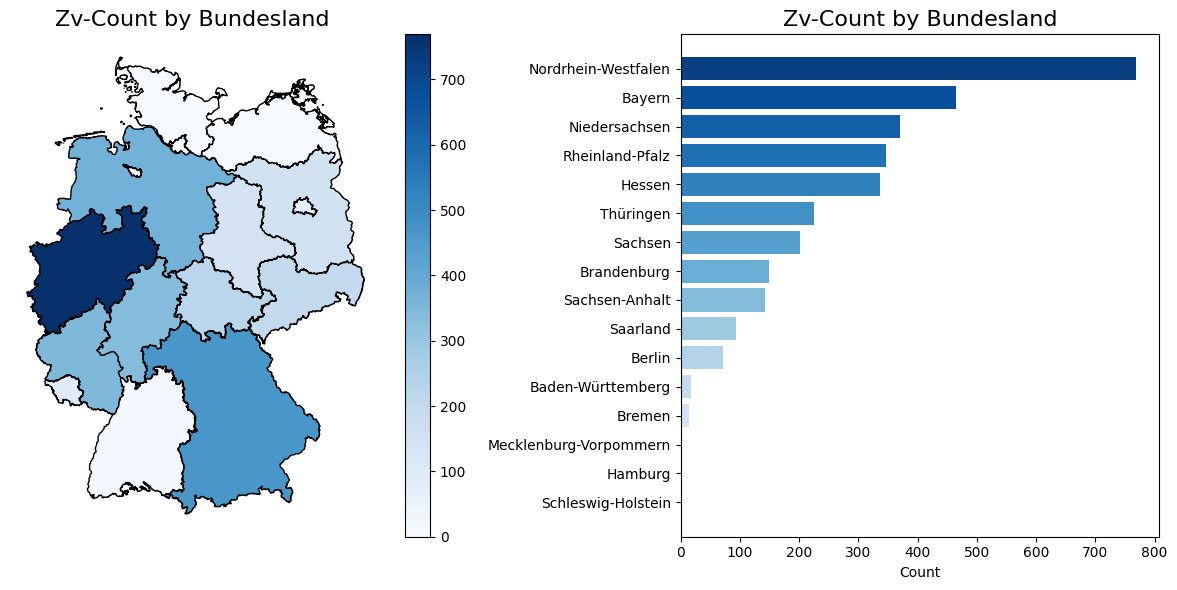

In [4]:
zv_counts = zv_df.groupby('bundesland_name').size().reset_index(name='count')
merged_gdf = grouped_gdf.merge(zv_counts, left_on='lan_name', right_on='bundesland_name', how='left')
merged_gdf['count'] = merged_gdf['count'].fillna(0)
visualize_data_by_bundesland(merged_gdf, column_name='count', title_prefix='Zv-Count', cmap_name="Blues")

#### Zv-Wohnungen for Bundesländer

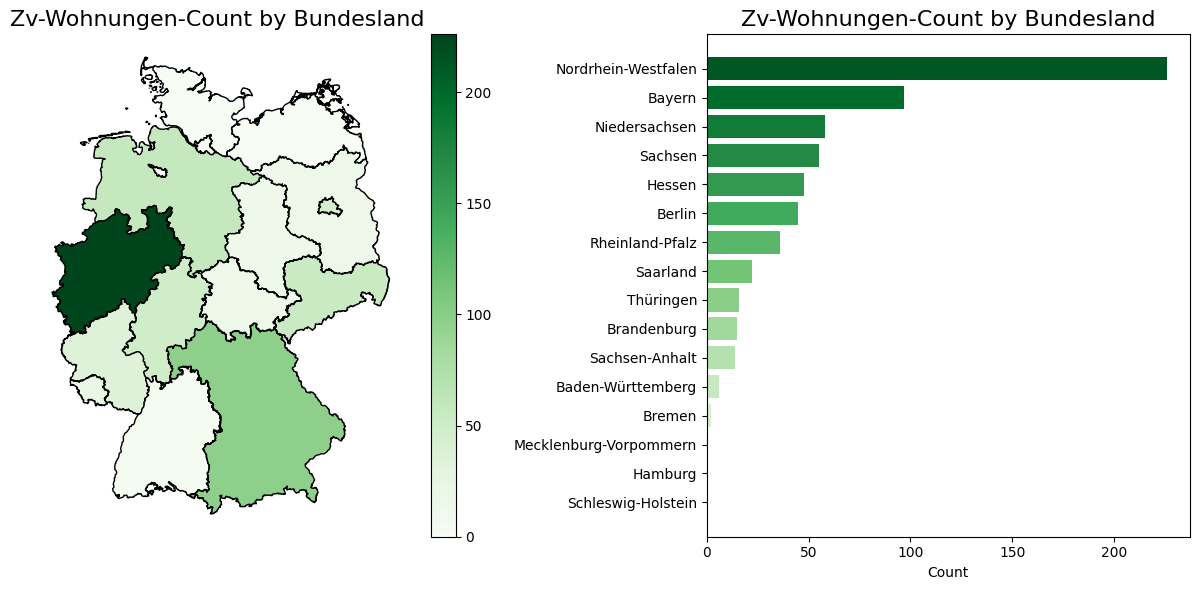

In [5]:
wohnungen_counts = wohnungen_df.groupby('bundesland_name').size().reset_index(name='count')
merged_gdf = grouped_gdf.merge(wohnungen_counts, left_on='lan_name', right_on='bundesland_name', how='left')
merged_gdf['count'] = merged_gdf['count'].fillna(0)
visualize_data_by_bundesland(merged_gdf, column_name='count', title_prefix='Zv-Wohnungen-Count', cmap_name="Greens")

#### Verkehrswert for Bundesländer

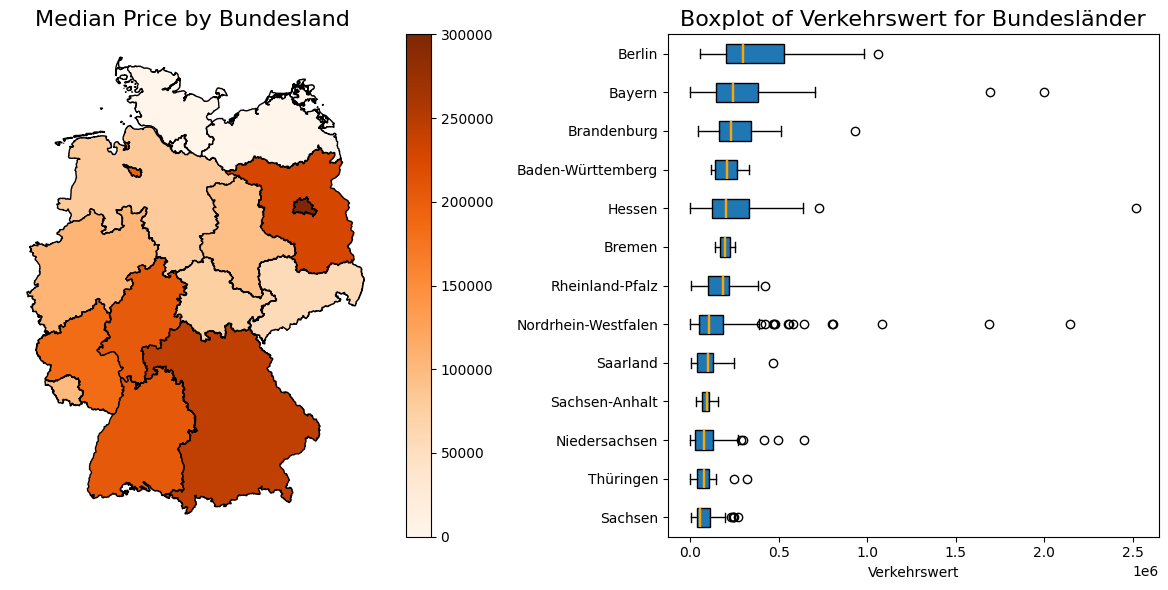

In [6]:
verkehrswert_agg = wohnungen_df.groupby('bundesland_name')['verkehrswert'].median().reset_index(name='verkehrswert')
merged_gdf = grouped_gdf.merge(verkehrswert_agg, left_on='lan_name', right_on='bundesland_name', how='left')
merged_gdf['verkehrswert'] = merged_gdf['verkehrswert'].fillna(0)
visualize_data_by_bundesland(merged_gdf, column_name='verkehrswert', title_prefix='Median Price', cmap_name="Oranges", boxplot_df=wohnungen_df.rename(columns={"bundesland_name" : "lan_name"}))

#### Look at distribution in Area(m^2) and Rooms

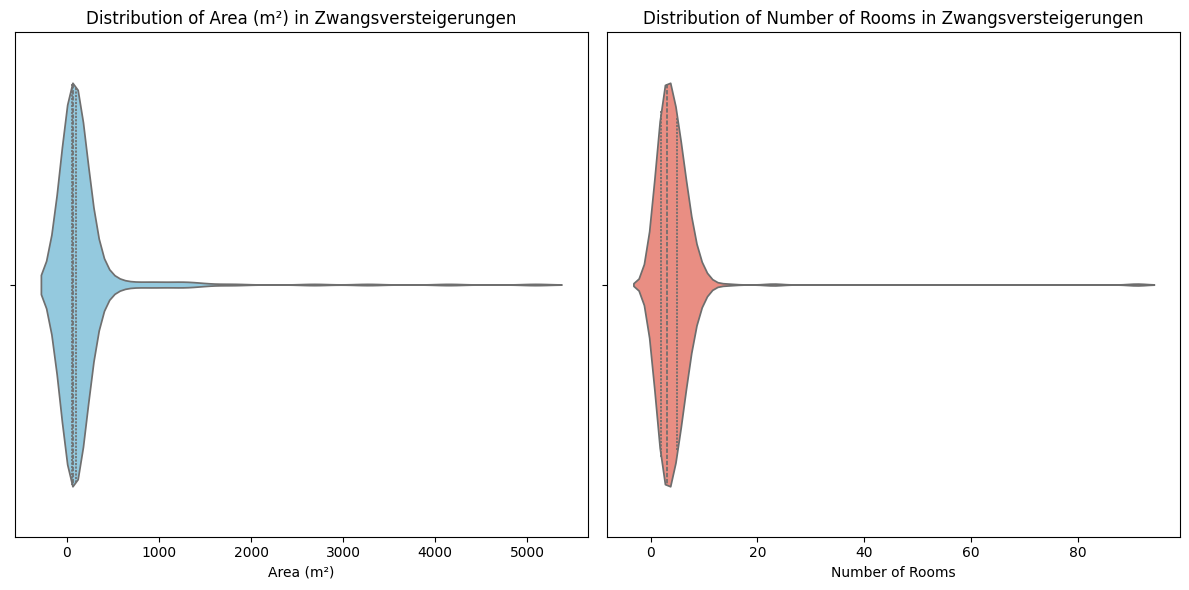

In [7]:
wohnungen_df = zv_df[zv_df['typ'] == 'Wohnung'].copy()
wohnungen_df_clean = wohnungen_df[['flaeche', 'raeume']].dropna()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.violinplot(data=wohnungen_df_clean, x='flaeche', inner='quart', color='skyblue')
plt.title('Distribution of Area (m²) in Zwangsversteigerungen')
plt.xlabel('Area (m²)')
plt.subplot(1, 2, 2)
sns.violinplot(data=wohnungen_df_clean, x='raeume', inner='quart', color='salmon')
plt.title('Distribution of Number of Rooms in Zwangsversteigerungen')
plt.xlabel('Number of Rooms')
plt.tight_layout()
plt.show()

#### Look for Correlations

Pearson Correlation between Rooms and Price: 0.11798735084277209
Spearman Correlation between Rooms and Price: 0.11381207094199412
Pearson Correlation between Construction Year and Price: 0.021648566814275717
Spearman Correlation between Construction Year and Price: 0.23514568104747638


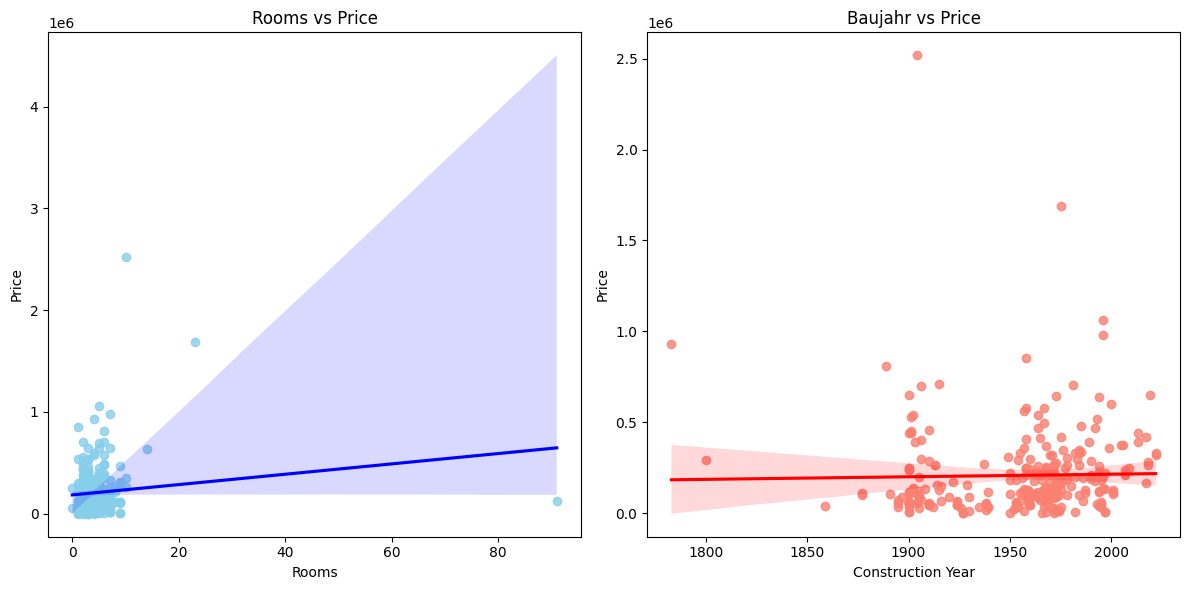

In [8]:
wohnungen_df_clean = wohnungen_df[['baujahr', 'raeume', 'verkehrswert']].dropna()

pearson_corr_rooms = wohnungen_df_clean['raeume'].corr(wohnungen_df_clean['verkehrswert'])
spearman_corr_rooms = wohnungen_df_clean['raeume'].corr(wohnungen_df_clean['verkehrswert'], method='spearman')

pearson_corr_price = wohnungen_df_clean['baujahr'].corr(wohnungen_df_clean['verkehrswert'])
spearman_corr_price = wohnungen_df_clean['baujahr'].corr(wohnungen_df_clean['verkehrswert'], method='spearman')

print(f"Pearson Correlation between Rooms and Price: {pearson_corr_rooms}")
print(f"Spearman Correlation between Rooms and Price: {spearman_corr_rooms}")
print(f"Pearson Correlation between Construction Year and Price: {pearson_corr_price}")
print(f"Spearman Correlation between Construction Year and Price: {spearman_corr_price}")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.regplot(data=wohnungen_df_clean, x='raeume', y='verkehrswert', scatter_kws={'color': 'skyblue'}, line_kws={'color': 'blue'})
plt.title(f'Rooms vs Price')
plt.xlabel('Rooms')
plt.ylabel('Price')

plt.subplot(1, 2, 2)
sns.regplot(data=wohnungen_df_clean, x='baujahr', y='verkehrswert', scatter_kws={'color': 'salmon'}, line_kws={'color': 'red'})
plt.title(f'Baujahr vs Price')
plt.xlabel('Construction Year')
plt.ylabel('Price')

plt.tight_layout()
plt.show()

### Compare Zwangsversteigerungen to Immoscout Apartments

In [ ]:

immo_df = pd.read_csv('data/immo_data.csv')
immo_df = immo_df[
    # I want to focus only on apartments, an apartment has specific characteristics which I will define on my own here
    # also I want to focus on apartments where it would be realistic to buy them
    (immo_df['yearConstructed'] >= wohnungen_df['baujahr'].min()) &
    (immo_df['baseRent'] <= np.percentile(immo_df['baseRent'], 99.9)) & # filter out > 4800
    (immo_df['livingSpace'] <= np.percentile(immo_df['livingSpace'], 99.9)) & # filter out > 280m^2
    (immo_df['noRooms'] <= 10)
]
immo_df = immo_df[['regio1', 'balcony', 'baseRent', 'yearConstructed', 'noRooms', 'livingSpace', 'garden']]
immo_df = immo_df.dropna()
immo_df['regio1'] = immo_df['regio1'].str.replace('_', '-')

#### Compare Distributions of Rent Price and Zwangsversteigerung Price

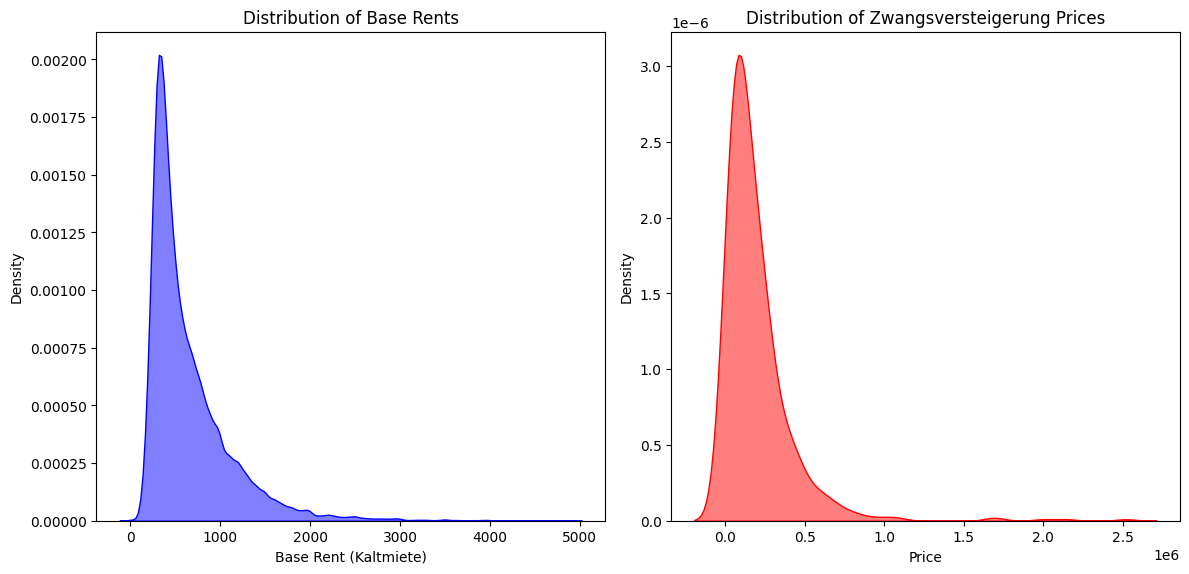

In [5]:
rent_prices = immo_df['baseRent']
zwangsversteigerung_prices = wohnungen_df['verkehrswert']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.kdeplot(rent_prices, ax=axes[0], color='blue', fill=True, alpha=0.5)
axes[0].set_title('Distribution of Base Rents')
axes[0].set_xlabel('Base Rent (Kaltmiete)')
axes[0].set_ylabel('Density')

sns.kdeplot(zwangsversteigerung_prices, ax=axes[1], color='red', fill=True, alpha=0.5)
axes[1].set_title('Distribution of Zwangsversteigerung Prices')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

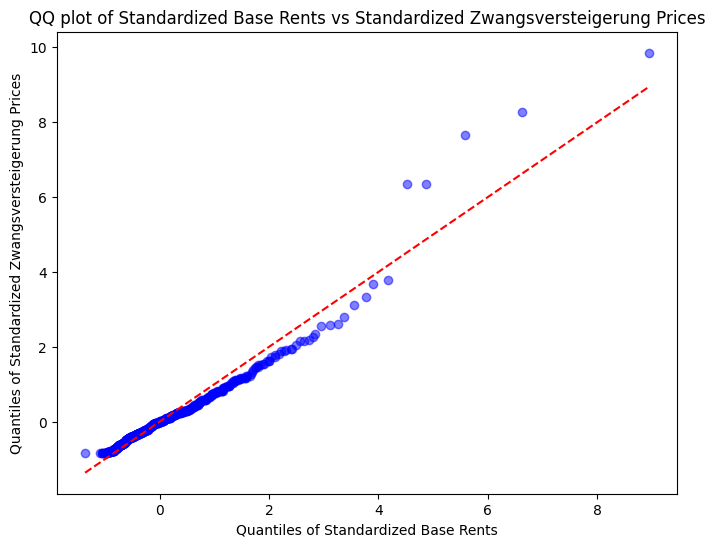

In [6]:
rent_prices = immo_df['baseRent']
rent_prices_standardized = (rent_prices - rent_prices.mean()) / rent_prices.std()

zwangsversteigerung_prices = wohnungen_df['verkehrswert']
zwangsversteigerung_prices_standardized = (zwangsversteigerung_prices - zwangsversteigerung_prices.mean()) / zwangsversteigerung_prices.std()

num_quantiles = min(len(rent_prices_standardized), len(zwangsversteigerung_prices_standardized))
quantiles_rent = np.percentile(rent_prices_standardized, np.linspace(0, 100, num_quantiles))
quantiles_zwangsversteigerung = np.percentile(zwangsversteigerung_prices_standardized, np.linspace(0, 100, num_quantiles))

plt.figure(figsize=(8, 6))
plt.scatter(quantiles_rent, quantiles_zwangsversteigerung, color='blue', alpha=0.5)
plt.plot(quantiles_rent, quantiles_rent, color='red', linestyle='--')
plt.title('QQ plot of Standardized Base Rents vs Standardized Zwangsversteigerung Prices')
plt.xlabel('Quantiles of Standardized Base Rents')
plt.ylabel('Quantiles of Standardized Zwangsversteigerung Prices')
plt.show()

#### Compare Construction years

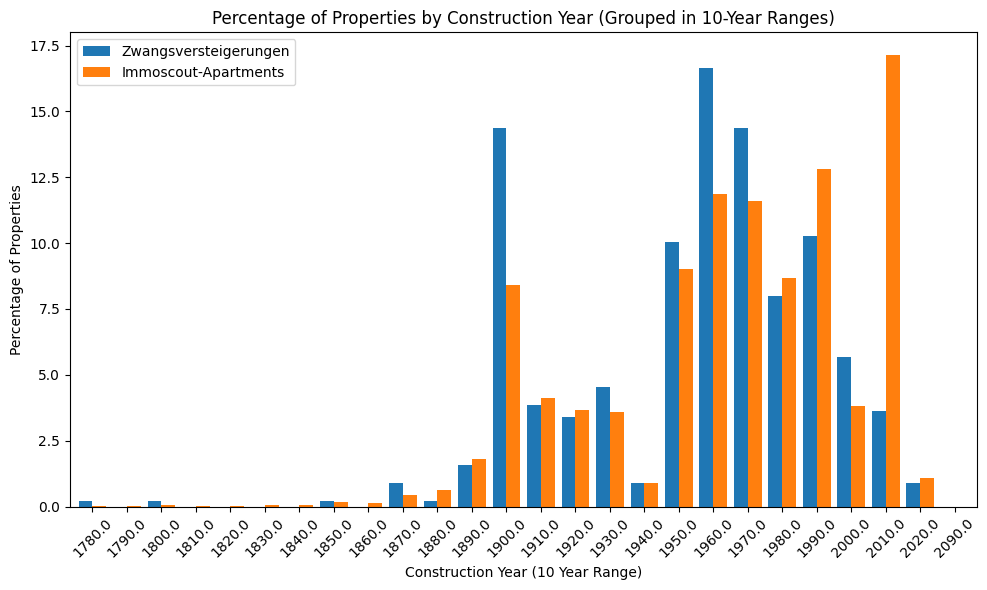

In [62]:
wohnungen_df = zv_df[zv_df['typ'] == 'Wohnung'].copy()
wohnungen_df['baujahr_group'] = (wohnungen_df['baujahr'] // 10) * 10
immo_df['baujahr_group'] = (immo_df['yearConstructed'] // 10) * 10

wohnungen_counts = wohnungen_df['baujahr_group'].value_counts(normalize=True).sort_index() * 100
immo_counts = immo_df['baujahr_group'].value_counts(normalize=True).sort_index() * 100

counts_df = pd.DataFrame({
    'Zwangsversteigerungen': wohnungen_counts,
    'Immoscout-Apartments': immo_counts
}).fillna(0)

counts_df.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Percentage of Properties by Construction Year (Grouped in 10-Year Ranges)')
plt.xlabel('Construction Year (10 Year Range)')
plt.ylabel('Percentage of Properties')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()